In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.colors import ListedColormap
from skimage import io

# general libraries
import os  
import json
import time
import h5py as h5py
import copy

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf, Workspace
from scalebars import *
import deconv

# import balance_configs as configs
import sac_mode_configs as configs
import experiments as exps
import analysis as ana
from interactive import MotionResponse

In [2]:
# %matplotlib notebook
# %matplotlib widget
%matplotlib ipympl
# %matplotlib qt
plt.rcParams.update({"figure.max_open_warning": 0})
plt.rcParams['svg.fonttype'] = 'none'  # don't save font as paths (assumes font present on machine)

In [3]:
base_path = "/mnt/Data/NEURONoutput/sac_net/"
model_path = os.path.join(base_path, "nmda_mult")
fig_dir_path = os.path.join(model_path, "figs") 
exts = [".png", ".svg"]

In [4]:
quanta_h5 = "/mnt/Data/prerna_velocity/static_roi_waveforms/quantum_pack.h5"
with h5.File(quanta_h5, "r") as f:
    quantum_pack = unpack_hdf(f)
    
release_rates = quantum_pack["clipped_rates"]
rec_dt = quantum_pack["rec_dt"]
# target_rate_dt = 0.001  # 0.0001
target_rate_dt = 0.005  # 0.0001
bp_inputs = {("sust" if k == "PD" else "trans"): r for k, r in quantum_pack["aligned_recs"].items()}
bp_inputs["sust"] = bp_inputs["sust"] * np.max(bp_inputs["trans"]) / np.max(bp_inputs["sust"])

vrate = deconv.velocity_rate(
    bp_inputs["trans"],
    rec_dt,
    quantum_pack["quantum"],
    1,
    rf=0.06,
    spot=0.2, # USUAL
    # spot=0.1, # CHANGED!
    # spot=0.05, # CHANGED!
    bsln_start=100,
    bsln_end=150,
    step=1,
    offset=0.,
    model_dt=target_rate_dt,
)
vrate = np.clip(vrate, 0.0, np.inf)

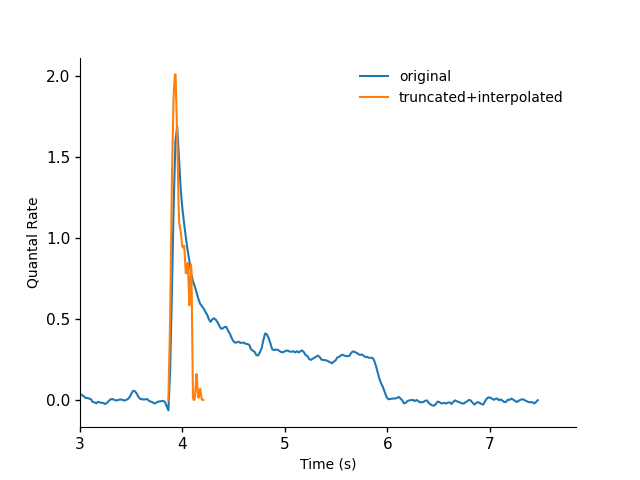

In [5]:
trans_rise = find_rise_bsln(bp_inputs["trans"], bsln_start=100, bsln_end=150, step=1) * rec_dt
rate_fig, rate_ax = plt.subplots(1)
rate_ax.plot(np.arange(len(bp_inputs["trans"])) * rec_dt, bp_inputs["trans"], label="original")
rate_ax.plot(np.arange(len(vrate)) * target_rate_dt + trans_rise, vrate, label="truncated+interpolated")
rate_ax.set_xlim(3)
rate_ax.set_xlabel("Time (s)")
rate_ax.set_ylabel("Quantal Rate")
rate_ax.legend(frameon=False)
clean_axes(rate_ax)

In [6]:
overwrite = True

save_name = "thesis_default"
# save_name = "thesis_gaba2x"
# save_name = "thesis_no_sac_offset"
# save_name = "thesis_ach0.7x"
# save_name = "thesis_dirsigslope0p05"
# save_name = "thesis_dirsigslope0p05_gaba1.5x"
save_name = "thesis_gaba2x_nmda2x"
# save_name = "thesis_dendK0.05"
# save_name = "thesis_dendK0.07"
# save_name = "thesis_ach0.8x_nmda2x"
# save_name = "thesis_ach0.9x_gaba1.2x_nmda2x"
# save_name = "thesis_gaba1.3x_nmda3x"
# save_name = "thesis_gaba2x_nmda3x"
# save_name = "thesis_nmda2x"

# save_name = "thesis_gaba2x_nmda2x_dendK0.07"
# save_name = "thesis_ach0.8x_nmda2x_dendK0.07"
# save_name = "thesis_ach0.9x_gaba1.2x_nmda2x_dendK0.07"
# save_name = "thesis_gaba1.3x_nmda3x_dendK0.07"
# save_name = "thesis_gaba2x_nmda3x_dendK0.07"
# save_name = "thesis_nmda2x_dendK0.07"

load_name = None

model_config = configs.thesis(
    ttx=False,
    non_ds_ach=False,
    offset_ampa_ach=False,
    poisson_rates={"sac": vrate / np.max(vrate), "glut": vrate / np.max(vrate), "dt": target_rate_dt},
    plexus=0,
    plexus_share=None,
    stacked_plex=False,
    record_tree=False, # TURN FALSE FOR RHO RANGE (more than 0 and 1)
)

# model_config["sac_dir_sigmoid_slope"] = 0.05  # (default=0.1)

model_config["synprops"]["E"]["weight"] = model_config["synprops"]["E"]["weight"]       * 1
model_config["synprops"]["PLEX"]["weight"] = model_config["synprops"]["PLEX"]["weight"] * 1
model_config["synprops"]["I"]["weight"] = model_config["synprops"]["I"]["weight"]       * 2
model_config["synprops"]["NMDA"]["weight"] = model_config["synprops"]["NMDA"]["weight"] * 2

# model_config["synprops"]["E"]["tau2"] = 3  # CHANGED!
# model_config["synprops"]["PLEX"]["tau2"] = 3  # CHANGED!
# model_config["synprops"]["I"]["tau2"] = 6 #6  # CHANGED!
# model_config["synprops"]["I"]["tau2"] = 3 #6  # CHANGED!
# model_config["synprops"]["NMDA"]["tau2"] = 6  # CHANGED!

# model_config["synprops"]["NMDA"]["pref_prob"] = 0.0
# model_config["synprops"]["NMDA"]["null_prob"] = 0.0

# model_config["synprops"]["E"]["tau1"] = 1.2  # CHANGED!
# model_config["synprops"]["PLEX"]["tau1"] = 1.2  # CHANGED!
# model_config["synprops"]["I"]["tau1"] = 0.6  # CHANGED!
# model_config["synprops"]["NMDA"]["tau1"] = 1.2  # CHANGED!

# model_config["max_sac_rho"] = 1 # NEW NORMAL!
# model_config["max_sac_rho"] = 0.0
# model_config["min_sac_rho"] = 0.0
# model_config["min_sac_rho"] = 0.95
# model_config["min_sac_rho"] = 1 # FLAT MODE ON

# model_config["diam_range"]["min"] = 0.5

# model_config["prime_Na"] = 0.0002 # alon dend (CHANGED!)
# model_config["prime_K"] = 0.007  # alon dend (CHANGED!)
# model_config["dend_Na"] = 0.0002 # alon dend (CHANGED!)
# model_config["dend_K"] = 0.007  # alon dend (CHANGED!)
# model_config["dend_Na"] = 0.01 # CHANGED!
# model_config["dend_K"] = 0.01 # CHANGED!
# model_config["dend_Na"] = 0.05 # CHANGED!
# model_config["dend_K"] = 0.05 # CHANGED!
# model_config["dend_Na"] = 0.015
# model_config["dend_K"] = 0.01
# model_config["soma_Na"] = 0.4 # CHANGED!
# model_config["soma_Na"] = 0.3  # CHANGED!
# model_config["dend_K"] = 0.07
    
# model_config["sac_offset"] = 0  # CHANGED!

# TESTING GLUTAMATE INSTEAD OF ACH
# model_config["sac_ach_offset"] = 0
# model_config["min_sac_rho"] = 0.5 # FLAT MODE ON
# model_config["max_sac_rho"] = 0.5 # FLAT MODE ON
# model_config["synprops"]["E"]["null_prob"] = 0.5
# model_config["synprops"]["E"]["pref_prob"] = 0.5

# model_config["synprops"]["AMPA"]["weight"] = model_config["synprops"]["E"]["weight"]
# model_config["synprops"]["AMPA"]["tau1"] = model_config["synprops"]["E"]["tau1"]
# model_config["synprops"]["AMPA"]["tau2"] = model_config["synprops"]["E"]["tau2"]
# model_config["synprops"]["AMPA"]["delay"] = model_config["synprops"]["E"]["delay"]
# model_config["synprops"]["AMPA"]["null_prob"] = 0.5
# model_config["synprops"]["AMPA"]["pref_prob"] = 0.5
# model_config["synprops"]["E"]["null_prob"] = 0
# model_config["synprops"]["E"]["pref_prob"] = 0

save_path = os.path.join(model_path, save_name) + ".h5"
if load_name is None:
    load_name = save_name
    if (not overwrite and os.path.exists(save_path)):
        print(
            "Loading %s rather than overwriting it.\nSet `overwrite = True` if saving over is desired."
            % save_name
        )
    else:
        from ei_balance_nogui import *
        os.makedirs(model_path, exist_ok=True)
        t0 = time.time()
        exps.sacnet_titration_run(
            save_path,
            model_config,
            n_nets=6,
            n_trials=3,
            rho_steps=[0.0, 1.0],
            param_paths=[["synprops", "NMDA", "weight"]],
            titration_steps=[0.0, 1.0],
            pool_sz=6,
            reset_seed_between_rho=True,
        )
        print("rho run time:", time.time() - t0)

hdf = h5.File(os.path.join(model_path, load_name) + ".h5", "r")
d = Workspace(hdf, read_only=True)
fig_path = os.path.join(fig_dir_path, load_name)
os.makedirs(fig_path, exist_ok=True)

factors = list(d.keys())
rhos = list(d[factors[0]].keys())
idxs = list(d[factors[0]][rhos[0]].keys())
print("==keys==")
print("factors:", factors)
print("rhos:", rhos)
print("idxs:", idxs)

Running with synprops/NMDA/weight scaled by factor of 0.00
  sac net trials 1 to 6 (of 6)...
Running with synprops/NMDA/weight scaled by factor of 1.00
  sac net trials 1 to 6 (of 6)...
Done!
rho run time: 609.5354676246643
==keys==
factors: [0.0, 1.0]
rhos: [0.0, 1.0]
idxs: [0, 1, 2, 3, 4, 5]


In [7]:
def close_button():
    button = widgets.Button(description="Close Workspace")
    out = widgets.Output()

    def on_clicked(_):
        with out:
            clear_output()
            d.close()
            print("File closed!")
        
    button.on_click(on_clicked)
    return widgets.VBox([button, out])

close_button()

In [8]:
metrics = {k: ana.get_sac_metrics(d[k]) for k in factors}

dir_labels = d[factors[0]][rhos[0]][idxs[0]]["params"]["dir_labels"][:]
sac_thetas = ana.get_sac_thetas(d[factors[0]])
sac_deltas = ana.get_sac_deltas(sac_thetas)

Impact of rho on DSI = 1.45


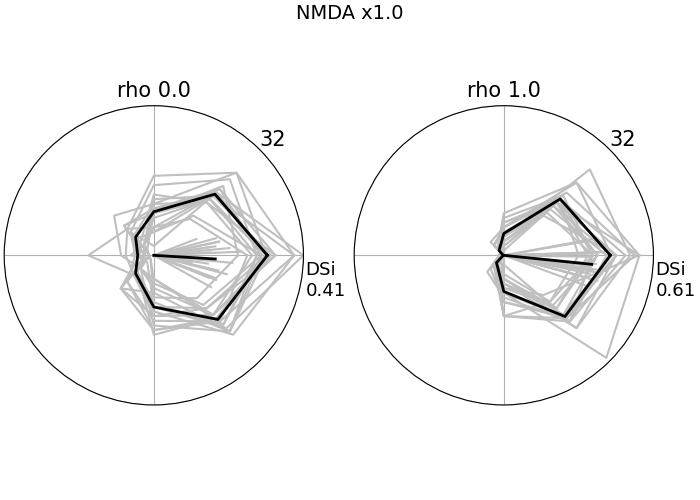

In [9]:
factor = 1.
max_spikes = np.max([r["spikes"] for r in metrics[factor].values()])
rho_dsi_impact = np.mean(metrics[factor][1.0]["avg_DSi"]) / np.mean(metrics[factor][0.0]["avg_DSi"])
print("Impact of rho on DSI = %.2f" % rho_dsi_impact)

focus_polar_fig = plt.figure(figsize=(7, 5))
n_cols = len(rhos)
focus_polar_ax = [
    polar_plot(
        m,
        dir_labels,
        title="rho " + str(r),
        radius=max_spikes,
        # radius=50,
        net_shadows=False,
        save=False,
        fig=focus_polar_fig,
        sub_loc=(1, n_cols, loc + 1),
        title_metrics=False,
    )
    for loc, (r, m) in enumerate(metrics[factor].items())
]
focus_polar_fig.suptitle("NMDA x%.1f" % (factor), fontsize=14)
focus_polar_fig.set_layout_engine("compressed")
for ext in [".png", ".svg"]:
    focus_polar_fig.savefig(
        os.path.join(fig_path, "NMDA_x%.1f_polars%s" % (factor, ext)), bbox_inches="tight")

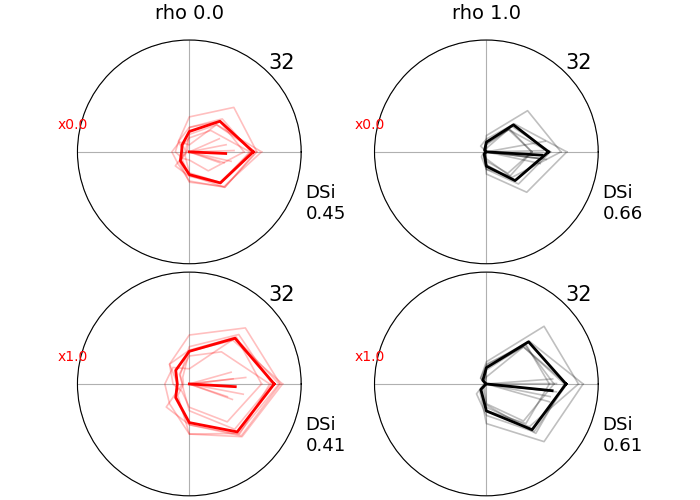

In [10]:
display_factors = factors

colours = ["red", "black"]

max_spikes = np.max([r["spikes"] for s in display_factors for r in metrics[s].values()])
polar_fig = plt.figure(figsize=(7, 5))
max_rows = 5
n_rows = min(max_rows, len(display_factors))
splits = int(np.ceil(len(display_factors) / max_rows))
n_cols = len(rhos) * splits
polar_ax = []
for i, factor in enumerate(display_factors):
    row = i % max_rows
    subcol = i // max_rows
    for j, (rho, m) in enumerate(metrics[factor].items()):
        polar_ax.append(polar(
            m["spikes"],
            dir_labels,
            title=None,
            title_metrics=False,
            radius=max_spikes,
            net_shadows=True,
            fig=polar_fig,
            sub_loc=(n_rows, n_cols, (row * n_cols + j * splits + subcol + 1)),
            dsi_tag_deg=-30,
            dsi_tag_mult=1.2,
            avg_colour=colours[j],
            shadow_alpha=0.25,
            shadow_linewidth=1.2,
        ))
        polar_ax[-1].text(np.radians(170), max_spikes * 1.2, ("x" + str(factor)), c="red")

for i in range(len(rhos)):
    polar_ax[i].set_title("rho %.1f" % rhos[i], fontsize=14, pad=15)

polar_fig.set_layout_engine("compressed")

lbl = "many" if len(display_factors) > 4 else "_".join(map(str, display_factors)).replace(".", "p")
for ext in [".png", ".svg"]:
    polar_fig.savefig(
        os.path.join(fig_path, "polar_grid_%s%s" % (lbl, ext)), bbox_inches="tight")

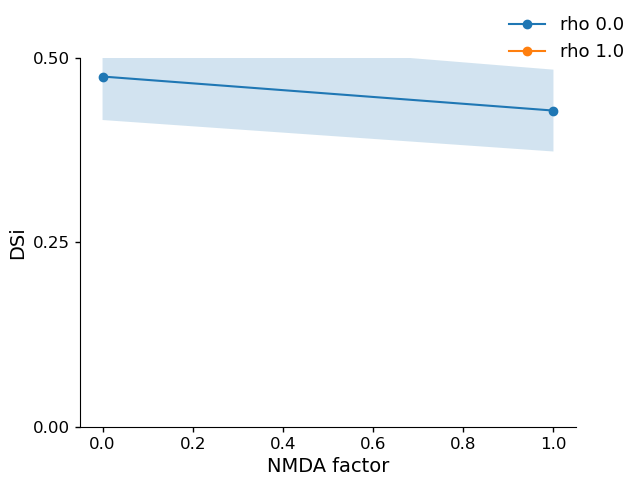

In [11]:
dsi_fig, dsi_ax = plt.subplots(1)

titration_dsis = {}
for rho in rhos:
    titration_dsis[rho] = {"nets": [], "avg": [], "std": []}
    for factor in factors:
        dsis = metrics[factor][rho]["DSis"]
        dsi_net_avgs = metrics[factor][rho]["DSis"].mean(axis=1)
        titration_dsis[rho]["nets"].append(dsi_net_avgs)
        titration_dsis[rho]["avg"].append(np.mean(dsi_net_avgs))
        titration_dsis[rho]["std"].append(np.std(dsi_net_avgs))
    titration_dsis[rho] = {m: np.array(v) for m, v in titration_dsis[rho].items()}
    titration_dsis[rho]["nets"] = titration_dsis[rho]["nets"].T
    dsi_ax.fill_between(
        factors, 
        titration_dsis[rho]["avg"] + titration_dsis[rho]["std"],
        titration_dsis[rho]["avg"] - titration_dsis[rho]["std"],
        alpha=0.2
    )
    dsi_ax.plot(factors, titration_dsis[rho]["avg"], marker="o", label="rho " + str(rho))
        
dsi_ax.set_ylabel("DSi", fontsize=14)
dsi_ax.set_xlabel("NMDA factor", fontsize=14)
dsi_ax.set_ylim(0, 0.5)
dsi_ax.set_yticks([0, 0.25, 0.5])

dsi_fig.legend(frameon=False, fontsize=13)
clean_axes(dsi_ax, ticksize=12)
for ext in [".png", ".svg"]:
    dsi_fig.savefig(os.path.join(fig_path, "dsi_vs_NMDA_factor%s" % (ext)), bbox_inches="tight")

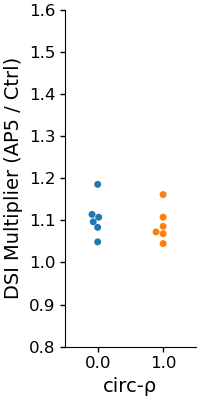

In [21]:
# make swarm plots of the DSI scales between NMDA on and off, as well as the impact of
# rho when NMDA is on and off (on DSI, null, and pre spiking)
dsi_scale_fig, dsi_scale_ax = plt.subplots(1, figsize=(2, 4))
dsi_scale_df = pd.DataFrame.from_dict(
    {str(r): metrics[0.0][r]["avg_DSi"] / metrics[1.0][r]["avg_DSi"] for r in rhos})

sns.swarmplot(dsi_scale_df, ax=dsi_scale_ax)

dsi_scale_ax.set_ylim(0.8, 1.6)
dsi_scale_ax.set_xlabel("circ-ρ", fontsize=14)
dsi_scale_ax.set_ylabel("DSI Multiplier (AP5 / Ctrl)", fontsize=14)
clean_axes(dsi_scale_ax, ticksize=12)
dsi_scale_fig.set_layout_engine("compressed")

for ext in [".png", ".svg"]:
    dsi_scale_fig.savefig(os.path.join(fig_path, "dsi_multiplier_swarm%s" % (ext)), bbox_inches="tight")

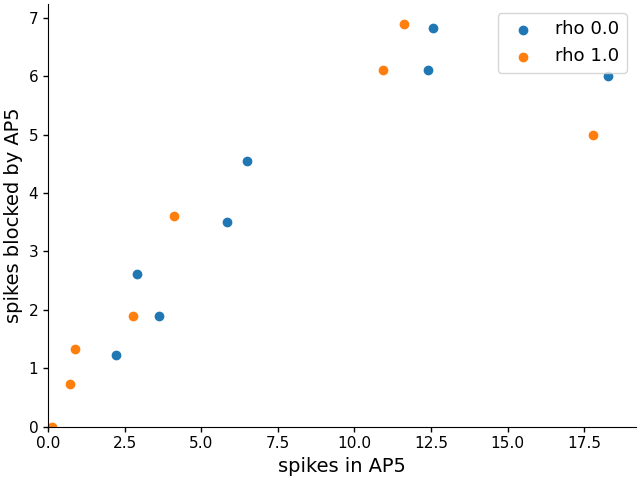

In [13]:
dir_scatter_fig, dir_scatter_ax = plt.subplots(1)

for rho in rhos:
    ap5_spks = np.mean(metrics[0.0][rho]["spikes"], axis=(0, 1))
    ctrl_spks = np.mean(metrics[1.0][rho]["spikes"], axis=(0, 1))
    blocked_spks = ctrl_spks - ap5_spks
    dir_scatter_ax.scatter(ap5_spks, blocked_spks, label="rho %.1f" % rho)
    
dir_scatter_ax.set_xlim(0)
dir_scatter_ax.set_ylim(0)

dir_scatter_ax.set_xlabel("spikes in AP5", fontsize=14)
dir_scatter_ax.set_ylabel("spikes blocked by AP5", fontsize=14)
dir_scatter_ax.legend(frameon=True, fontsize=13)

clean_axes(dir_scatter_ax)
dir_scatter_fig.set_layout_engine("compressed")

for ext in [".png", ".svg"]:
    dir_scatter_fig.savefig(os.path.join(fig_path, "spikes_blocked_by_ap5%s" % (ext)), bbox_inches="tight")

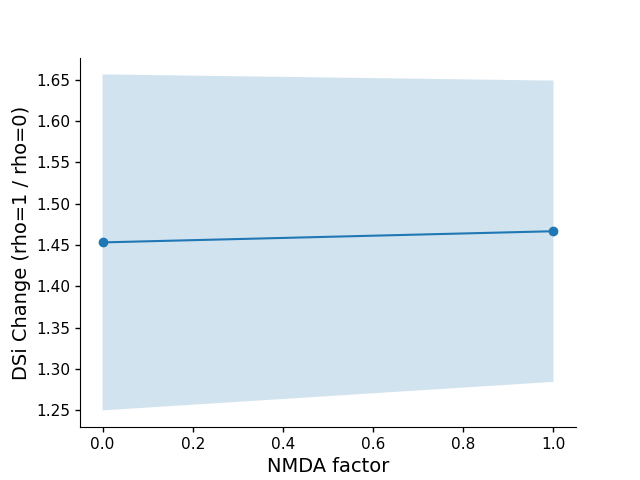

In [14]:
rho_dsi_effect_fig, rho_dsi_effect_ax = plt.subplots(1)
dsi_effect_nets = titration_dsis[1.0]["nets"] / titration_dsis[0.0]["nets"]
dsi_effect_avg = np.mean(dsi_effect_nets, axis=0)
dsi_effect_std = np.std(dsi_effect_nets, axis=0)

rho_dsi_effect_ax.fill_between(
    factors, 
    dsi_effect_avg + dsi_effect_std,
    dsi_effect_avg - dsi_effect_std,
    alpha=0.2
)
rho_dsi_effect_ax.plot(factors, dsi_effect_avg, marker="o")

rho_dsi_effect_ax.set_ylabel("DSi Change (rho=1 / rho=0)", fontsize=14)
rho_dsi_effect_ax.set_xlabel("NMDA factor", fontsize=14)
# rho_dsi_effect_ax.set_xscale("log")

clean_axes(rho_dsi_effect_ax)
for ext in exts:
    rho_dsi_effect_fig.savefig(os.path.join(
        fig_path, "NMDA_dsi_effect_of_rho%s" % (ext)), bbox_inches="tight")

In [15]:
avg_spikes = {
    fac: {rho: np.mean(nets["spikes"], axis=(0, 1)) for rho, nets in exps.items()}
    for fac, exps in metrics.items()
}
std_spikes = {
    fac: {rho: np.std(nets["spikes"], axis=(0, 1)) for rho, nets in exps.items()}
    for fac, exps in metrics.items()
}

dirs_180 = np.array([ana.scale_180_from_360(d) for d in  dir_labels])
dir_sort = np.argsort(dirs_180)
dirs_sorted = dir_labels[dir_sort]
dirs_180_sorted = dirs_180[dir_sort]
if np.max(dirs_180) < 180:
    wrap_circ = lambda ds: np.r_[ds, ds[0]]
    circ_180 = np.r_[dirs_180_sorted, -dirs_180_sorted[0]]
else:
    wrap_circ = lambda ds: np.r_[ds[-1], ds] 
    circ_180 = np.r_[-dirs_180_sorted[-1], dirs_180_sorted] 

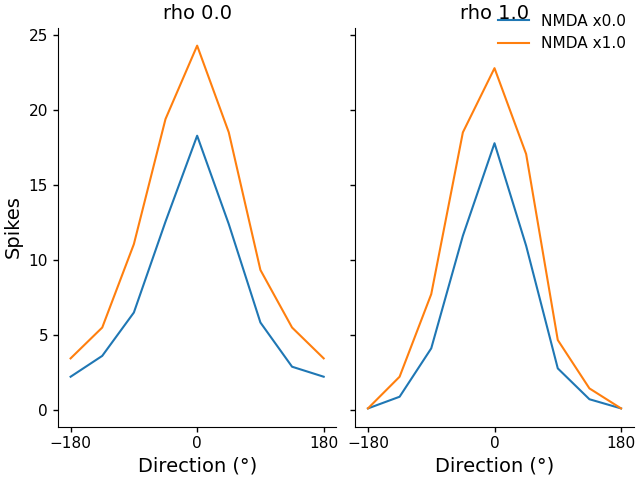

In [16]:
tuning_fig, tuning_ax = plt.subplots(1, len(rhos), sharey=True)
for i, (ax, rho) in enumerate(zip(tuning_ax, rhos)):
    ax.set_xlabel("Direction (°)", fontsize=14)
    ax.set_title("rho " + str(rho), fontsize=14)
    for factor in factors:
        lbl = ("NMDA x" + str(factor)) if not i else None
        ax.plot(circ_180, wrap_circ(avg_spikes[factor][rho][dir_sort]), label=lbl)
    ax.set_xticks([-180, 0, 180])
tuning_ax[0].set_ylabel("Spikes", fontsize=14)
tuning_fig.legend(frameon=False, fontsize=11)
clean_axes(tuning_ax)
tuning_fig.set_layout_engine("compressed")
for ext in exts:
    tuning_fig.savefig(os.path.join(fig_path, "NMDA_tuning%s"  % (ext)), bbox_inches="tight")

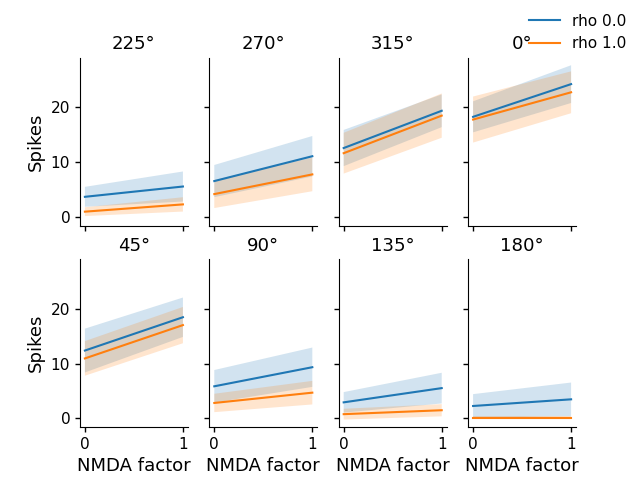

In [17]:
dir_grid_fig, dir_grid_ax = plt.subplots(2, 4, sharex=True, sharey=True)

i = 0
for row in dir_grid_ax:
    row[0].set_ylabel("Spikes", fontsize=13)
    for ax in row:
        for rho in rhos:
            spks = np.array([avg_spikes[factor][rho][i] for factor in factors])
            stds = np.array([std_spikes[factor][rho][i] for factor in factors])
            lbl = ("rho " + str(rho)) if not i else None
            ax.fill_between(factors, spks + stds, spks - stds, alpha=0.2)
            ax.plot(factors, spks, label=lbl)
            ax.set_title("%i°" % dir_labels[i], fontsize=13)
        i += 1

for col in dir_grid_ax.T:
    col[-1].set_xlabel("NMDA factor", fontsize=13)

# dir_grid_ax[0, 0].invert_xaxis()
# dir_grid_ax[0, 0].set_xscale("log")
dir_grid_fig.legend(frameon=False, fontsize=11)
clean_axes(dir_grid_ax)
for ext in exts:
    dir_grid_fig.savefig(os.path.join(
        fig_path, "NMDA_dir_spikes_grid%s" % (ext)), bbox_inches="tight")

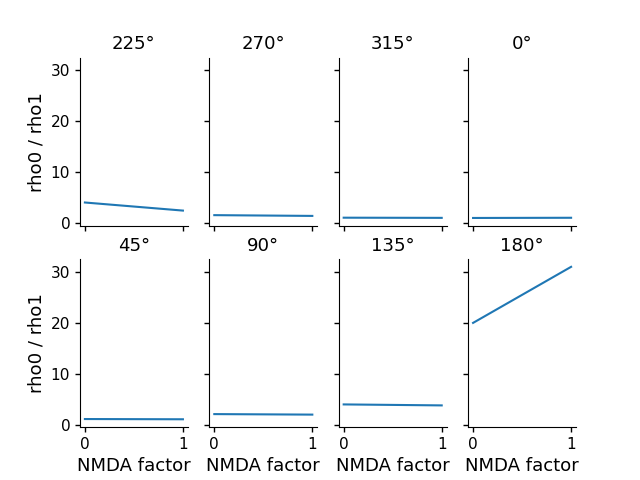

In [18]:
dir_mult_grid_fig, dir_mult_grid_ax = plt.subplots(2, 4, sharex=True, sharey=True)

i = 0
for row in dir_mult_grid_ax:
    row[0].set_ylabel("rho0 / rho1", fontsize=13)
    for ax in row:
        rho0_spks = np.array([avg_spikes[factor][0.0][i] for factor in factors])
        rho1_spks = np.array([avg_spikes[factor][1.0][i] for factor in factors])
        ax.plot(factors, rho0_spks / rho1_spks)
        ax.set_title("%i°" % dir_labels[i], fontsize=13)
        i += 1

for col in dir_mult_grid_ax.T:
    col[-1].set_xlabel("NMDA factor", fontsize=13)
        
clean_axes(dir_mult_grid_ax)
for ext in exts:
    dir_mult_grid_fig.savefig(os.path.join(
        fig_path, "NMDA_dir_spikes_effect_of_rho_grid%s" % (ext)), bbox_inches="tight")

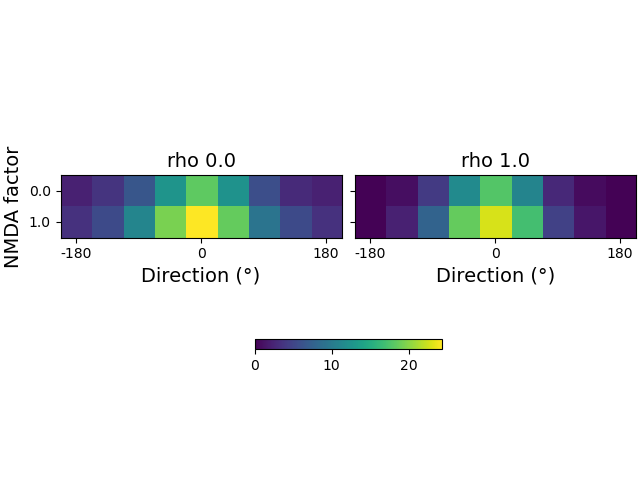

In [19]:
tuning_mat_fig, tuning_mat_ax = plt.subplots(1, 2, sharey=True)

avg_spike_mats = {
    rho: np.stack(
        [wrap_circ(avg_spikes[factor][rho][dir_sort]) for factor in factors], axis=0)
    for rho in rhos
}
avg_max_spikes = np.max([m.max() for m in avg_spike_mats.values()])
avg_spike_imgs = {}

vmax = avg_max_spikes
# vmax = 20.0

for i, (ax, rho) in enumerate(zip(tuning_mat_ax, rhos)):
    ax.set_xlabel("Direction (°)", fontsize=14)
    ax.set_title("rho " + str(rho), fontsize=14)
    avg_spike_imgs[rho] = ax.imshow(avg_spike_mats[rho], vmin=0, vmax=vmax, cmap="viridis")
    ax.set_xticks([0, 4, 8])
    ax.set_xticklabels([-180, 0, 180])
    ax.set_yticks(range(len(factors)))
    ax.set_yticklabels(factors)
    
tuning_mat_ax[0].set_ylabel("NMDA factor", fontsize=14)
tuning_mat_fig.colorbar(
    avg_spike_imgs[rhos[-1]], ax=tuning_mat_ax, orientation="horizontal")
tuning_mat_fig.set_layout_engine("compressed")
for ext in exts:
    tuning_mat_fig.savefig(os.path.join(
        fig_path, "NMDA_tuning_matrices%s" % (ext)), bbox_inches="tight")

In [20]:
close_button()